# What variables differentially affect change in state uninsured rates post Affordable Care Act?

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re #regular expressions
import scipy.stats
import datetime as dt
%matplotlib inline
import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn  import preprocessing
from sklearn.decomposition import PCA 
from sklearn import ensemble
from sklearn.model_selection import cross_val_score, GridSearchCV

In [163]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

The rate of uninsured individuals fell considerably post implementation of the Affordable Care Act. There is large variability in the effect size between states. This project will aim to explore what variables can potentially describe the variance in effect size. Understanding the variance in these changes could inform future legislation and could also be used to target externalities in the provision of healthcare.

In [17]:
state_aca_df = pd.read_csv('states.csv')

In [3]:
state_aca_df.head()

,State,uninsured_rate_2010,uninsured_rate_2015,uninsured_rate_change,insurance_coverage_change,employer_health_coverage_2015,marketplace_health_coverage_2016,marketplace_tax_credits_2016,average_monthly_tax_credit_2016,medicaid_expansion,medicaid_enrollment_2013,medicaid_enrollment_2016,medicaid_enrollment_change,medicare_enrollment_2016
0,Alabama,14.60%,10.10%,-4.50%,215000,2545000,165534,152206,$310,False,799176.0,910775,111599.0,989855
1,Alaska,19.90%,14.90%,-5%,36000,390000,17995,16205,$750,True,122334.0,166625,44291.0,88966
2,Arizona,16.90%,10.80%,-6.10%,410000,3288000,179445,124346,$230,True,1201770.0,1716198,514428.0,1175624
3,Arkansas,17.50%,9.50%,-8%,234000,1365000,63357,56843,$306,True,556851.0,920194,363343.0,606146
4,California,18.50%,8.60%,-9.90%,3826000,19552000,1415428,1239893,$309,True,7755381.0,11843081,4087700.0,5829777


In [165]:
#need to convert percentage strings to integer

state_aca_df['uninsured_rate_change']=state_aca_df.uninsured_rate_change.str.replace("%", "")

state_aca_df['uninsured_rate_change']=state_aca_df['uninsured_rate_change'].apply(pd.to_numeric)

state_aca_df['uninsured_rate_2010']=state_aca_df.uninsured_rate_2010.str.replace("%", "")

state_aca_df['uninsured_rate_2010']=state_aca_df['uninsured_rate_2010'].apply(pd.to_numeric)

state_aca_df['uninsured_rate_2015']=state_aca_df.uninsured_rate_2015.str.replace("%", "")

state_aca_df['uninsured_rate_2015']=state_aca_df['uninsured_rate_2015'].apply(pd.to_numeric)

#quick check

#state_aca_df.head()


------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------

## Feature Engineering and cleaning

In [19]:
#create variable that describes politcal lean of state
#data taken from https://news.gallup.com/poll/181475/massachusetts-maryland-democratic-states.aspx?utm_source=Politics&utm_medium=newsfeed&utm_campaign=tiles
state_aca_df['State']=state_aca_df.State.str.replace(" ", "")
state_aca_df['State']=state_aca_df.State.str.lower()

#Create new binrary variable for political lean
#state_aca_df['political_lean']=np.where((state_aca_df['State'].isin(['california','washington','newmexico',
                                                                     #'michigan','illinois','oregon','pennsylvania', 'newyork',
                                                                     #'maryland','delaware','newjersey','conneticut','rhodeisland',
                                                                     #'massacheusets','vermont','newhampshire','maine','hawaii'])), 1, 0)

#might be better to create a categorical variable that includes neutral states
political_lean=[]

for row in state_aca_df['State']:
    # if more than a value,
    if row in ['california','washington','newmexico','michigan','illinois','oregon','pennsylvania', 'newyork',
               'maryland','delaware','newjersey','conneticut','rhodeisland','massacheusets','vermont','newhampshire','maine','hawaii']:
        # Append a scaled variable where 2=left leaning
        political_lean.append('2')
    # else, if more than a value,
    elif row in ['alaska','utah','wyoming','indiana','arizona','tennessee','montana','northdakota','southdakota','nebraska','kansas','mississipi','alabama']:
        # Append a scaled variable where 0= right leaning
        political_lean.append('0')
    # append a scaled variable where 1=neutral political lean
    else:
        political_lean.append('1')
    #create a column based on this output
state_aca_df['political_lean'] = political_lean
            
            
#quick check
print(state_aca_df['political_lean'])

0     0
1     0
2     0
3     1
4     2
5     1
6     1
7     2
8     1
9     1
10    1
11    2
12    1
13    2
14    0
15    1
16    0
17    1
18    1
19    2
20    2
21    1
22    2
23    1
24    1
25    1
26    0
27    0
28    1
29    2
30    2
31    2
32    2
33    1
34    0
35    1
36    1
37    2
38    2
39    2
40    1
41    0
42    0
43    1
44    0
45    2
46    1
47    2
48    1
49    1
50    0
Name: political_lean, dtype: object


In [20]:
#type above is an object..need to cast that to an integer

state_aca_df['political_lean']=state_aca_df['political_lean'].apply(pd.to_numeric)

#create a variable that describes state GDP per capita

gdp_per_cap_df = pd.read_csv('gdp_per_capita_USA_2010_2015.csv')

state_aca_df['gdppercap_2010']=gdp_per_cap_df['gdppercap_2010']
state_aca_df['gdppercap_2011']=gdp_per_cap_df['gdppercap_2011']
state_aca_df['gdppercap_2012']=gdp_per_cap_df['gdppercap_2012']
state_aca_df['gdppercap_2013']=gdp_per_cap_df['gdppercap_2013']
state_aca_df['gdppercap_2014']=gdp_per_cap_df['gdppercap_2014']
state_aca_df['gdppercap_2015']=gdp_per_cap_df['gdppercap_2015']

#KFF.org has a lot of descriptive data on state healthcare status, i'm going to add some of that data for future analyses

kff_df= pd.read_csv('kff_data.csv')
#remove $ signs
kff_df['health_expense_per_cap_2014']=kff_df.health_expense_per_cap_2014.str.replace("$", "")
kff_df['health_expense_per_cap_2013']=kff_df.health_expense_per_cap_2013.str.replace("$", "")
kff_df['health_expense_per_cap_2012']=kff_df.health_expense_per_cap_2012.str.replace("$", "")
kff_df['health_expense_per_cap_2011']=kff_df.health_expense_per_cap_2011.str.replace("$", "")
kff_df['health_expense_per_cap_2010']=kff_df.health_expense_per_cap_2010.str.replace("$", "")
kff_df['health_expense_per_cap_2009']=kff_df.health_expense_per_cap_2009.str.replace("$", "")
kff_df['private_health_insurance_spending_millions']=kff_df.private_health_insurance_spending_millions.str.replace("$", "")
#remove ,
kff_df['health_expense_per_cap_2014']=kff_df.health_expense_per_cap_2014.str.replace(",", "")
kff_df['health_expense_per_cap_2013']=kff_df.health_expense_per_cap_2013.str.replace(",", "")
kff_df['health_expense_per_cap_2012']=kff_df.health_expense_per_cap_2012.str.replace(",", "")
kff_df['health_expense_per_cap_2011']=kff_df.health_expense_per_cap_2011.str.replace(",", "")
kff_df['health_expense_per_cap_2010']=kff_df.health_expense_per_cap_2010.str.replace(",", "")
kff_df['health_expense_per_cap_2009']=kff_df.health_expense_per_cap_2009.str.replace(",", "")
kff_df['private_health_insurance_spending_millions']=kff_df.private_health_insurance_spending_millions.str.replace(",", "")
#create corresponding variables in original database
state_aca_df['health_expense_per_cap_2014']=kff_df['health_expense_per_cap_2014'].apply(pd.to_numeric)
state_aca_df['health_expense_per_cap_2013']=kff_df['health_expense_per_cap_2013'].apply(pd.to_numeric)
state_aca_df['health_expense_per_cap_2012']=kff_df['health_expense_per_cap_2012'].apply(pd.to_numeric)
state_aca_df['health_expense_per_cap_2011']=kff_df['health_expense_per_cap_2011'].apply(pd.to_numeric)
state_aca_df['health_expense_per_cap_2010']=kff_df['health_expense_per_cap_2010'].apply(pd.to_numeric)
state_aca_df['health_expense_per_cap_2009']=kff_df['health_expense_per_cap_2009'].apply(pd.to_numeric)
state_aca_df['private_health_insurance_spending_millions']=kff_df['private_health_insurance_spending_millions'].apply(pd.to_numeric)

#add federal poverty line distributions for each state
state_aca_df['2015_under_fed_pl']=kff_df['2015_under_fed_pl']
state_aca_df['2010_under_fed_pl']=kff_df['2010_under_fed_pl']

state_aca_df['2015_100_199_fedpl']=kff_df['2015_100_199_fedpl']
state_aca_df['2010_100_199_fedpl']=kff_df['2010_100_199_fedpl']

state_aca_df['2015_200_399_fedpl']=kff_df['2015_200_399_fedpl']
state_aca_df['2010_200_399_fedpl']=kff_df['2010_200_399_fedpl']

state_aca_df['2015_over400_pl']=kff_df['2015_over400_pl']
state_aca_df['2010_over400_pl']=kff_df['2010_over400_pl']

In [21]:
#cleaning I missed

state_aca_df['average_monthly_tax_credit_2016']=state_aca_df['average_monthly_tax_credit_2016'].str.replace("$", "")
state_aca_df['average_monthly_tax_credit_2016']=state_aca_df['average_monthly_tax_credit_2016'].apply(pd.to_numeric)

------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------

# Data Exploration

First we need to take a look at variance and distribution of effect size in rate change and which variables correlated with this rate change.

## How does the uninsured rate and the change in uninsured rate pre and post ACA vary by state?

In [153]:
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np


data = [go.Histogram(x=state_aca_df['uninsured_rate_change'])]

nbinsx=12

layout = go.Layout(
    title='Distribution of change in % individuals uninsured by state',
    xaxis=dict(
        title='Change in % of individuals uninsured'
    ),
    yaxis=dict(
        title='# of states'
    ),
    bargap=0.1,
    bargroupgap=0.1
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='styled histogram')


D:\Anaconda\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [161]:
trace1 = go.Histogram(
    x=state_aca_df['uninsured_rate_2010'],
    opacity=0.6,
    name = '2010 % individuals uninsured',
    xbins=dict(
        size=1
    )
)
trace2 = go.Histogram(
    x=state_aca_df['uninsured_rate_2015'],
    opacity=0.75,
    name = '2015 % individuals uninsured',
    xbins=dict(
        size=1
    )
)

data = [trace1, trace2]
layout = go.Layout(barmode='overlay', title = 'Distribution of uninsured rate by state in 2010 and 2015' )


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='overlaid histogram')

D:\Anaconda\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



The data looks normally distributed as expected. The range in rate change is from -10.0% to +5.0%. By eye, it is hard to tell if the variance in uninsured rates is consistent between pre and post ACA measures. Let's take a closer look at the descriptive statistical variables to ensure that this is the case.

In [167]:
print(state_aca_df['uninsured_rate_change'].describe())

count    51.000000
mean     -5.433333
std       2.133229
min     -10.300000
25%      -6.600000
50%      -5.000000
75%      -3.950000
max      -1.600000
Name: uninsured_rate_change, dtype: float64


The mean and 50% percentile are quite close together. Let's take a quick look at how the states below and above the 50% percentile compare to each other:

In [171]:
lowestchange_df = state_aca_df[state_aca_df['uninsured_rate_change'] > -5]
highestchange_df = state_aca_df[state_aca_df['uninsured_rate_change'] < -5]

print(lowestchange_df.describe())


       uninsured_rate_2010  uninsured_rate_2015  uninsured_rate_change  \
count             25.00000             25.00000              25.000000   
mean              11.01600              7.26400              -3.752000   
std                2.69887              2.47805               0.979847   
min                4.40000              2.80000              -4.800000   
25%                9.30000              5.70000              -4.500000   
50%               11.10000              7.10000              -3.900000   
75%               13.20000              9.10000              -3.400000   
max               15.30000             11.50000              -1.600000   

       insurance_coverage_change  employer_health_coverage_2015  \
count                  25.000000                   2.500000e+01   
mean               181440.000000                   2.655640e+06   
std                203192.658988                   2.540824e+06   
min                 15000.000000                   3.350000e+05  

In [172]:
print(highestchange_df.describe())

       uninsured_rate_2010  uninsured_rate_2015  uninsured_rate_change  \
count            24.000000            24.000000              24.000000   
mean             16.987500             9.766667              -7.220833   
std               3.045497             3.032816               1.570926   
min              12.200000             5.700000             -10.300000   
25%              14.750000             6.900000              -8.150000   
50%              17.200000            10.200000              -6.650000   
75%              18.275000            11.675000              -5.875000   
max              23.700000            17.100000              -5.200000   

       insurance_coverage_change  employer_health_coverage_2015  \
count               2.400000e+01                   2.400000e+01   
mean                6.177083e+05                   4.315125e+06   
std                 8.043126e+05                   4.514756e+06   
min                 5.800000e+04                   5.100000e+05  

Text(0, 0.5, 'Change in % Uninsured')

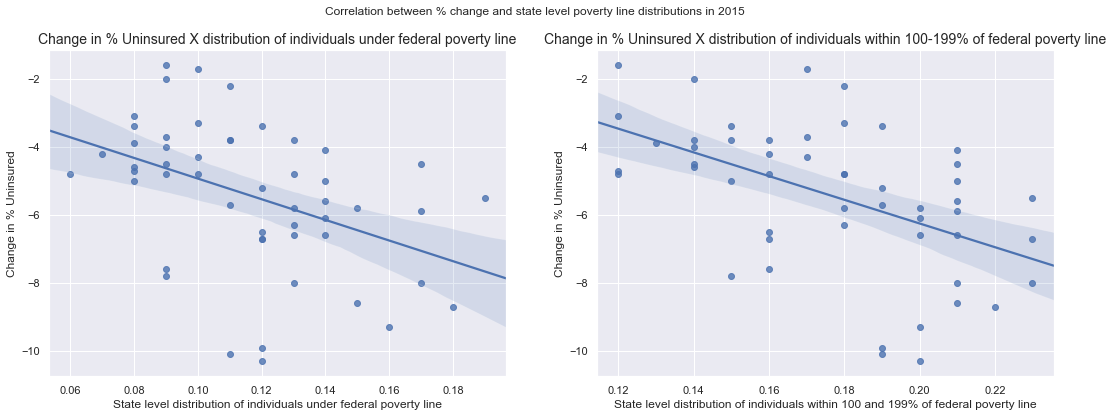

In [23]:
plt.figure(figsize=(18,6))

plt.subplot(1, 2, 1)
plt.suptitle('Correlation between % change and state level poverty line distributions in 2015')
sns.set(style="darkgrid")
sns.regplot(state_aca_df['2015_under_fed_pl'], state_aca_df['uninsured_rate_change'])
plt.title('Change in % Uninsured X distribution of individuals under federal poverty line', fontsize=14)
plt.xlabel('State level distribution of individuals under federal poverty line')
plt.ylabel('Change in % Uninsured')

plt.subplot(1, 2, 2)
sns.set(style="darkgrid")
sns.regplot(state_aca_df['2015_100_199_fedpl'], state_aca_df['uninsured_rate_change'])
plt.title('Change in % Uninsured X distribution of individuals within 100-199% of federal poverty line', fontsize=14)
plt.xlabel('State level distribution of individuals within 100 and 199% of federal poverty line')
plt.ylabel('Change in % Uninsured')

In [9]:
print('State Uninsured Rate stats - 2010')
print(state_aca_df['uninsured_rate_2010'].describe())
print("\n")
print('State Uninsured Rate stats - 2015')
print(state_aca_df['uninsured_rate_2015'].describe())

#Ratio of stf to mean pre and post ACA
print("\n")
print('Coefficient of Variation for Uninsured Rate in 2010')
print(4.164/14.180769)
print("\n")
print('Coefficient of Variation for Uninsured Rate in 2015')
print(3.142678/8.734615)

State Uninsured Rate stats - 2010
count    51.000000
mean     14.154902
std       4.201300
min       4.400000
25%      11.200000
50%      14.200000
75%      17.400000
max      23.700000
Name: uninsured_rate_2010, dtype: float64


State Uninsured Rate stats - 2015
count    51.000000
mean      8.721569
std       3.172527
min       2.800000
25%       6.200000
50%       8.600000
75%      10.900000
max      17.100000
Name: uninsured_rate_2015, dtype: float64


Coefficient of Variation for Uninsured Rate in 2010
0.2936371081145176


Coefficient of Variation for Uninsured Rate in 2015
0.3597958238571477


As expected there is larger relative variance in the state Uninsured Rate in 2015 as compared to 2010. This suggests that the effect of ACA wasn't homogenous among states. This is further corroborated by the distribution in Plot 1.

Accordingly, it should be investigated if there are any variables that predict the variance in effect size. Before this, it would be prudent to feature engineere some additional variables into this dataset.

## What variables associate with the change in % uninsured pre and post-ACA

Text(0, 0.5, 'Change in % Uninsured')

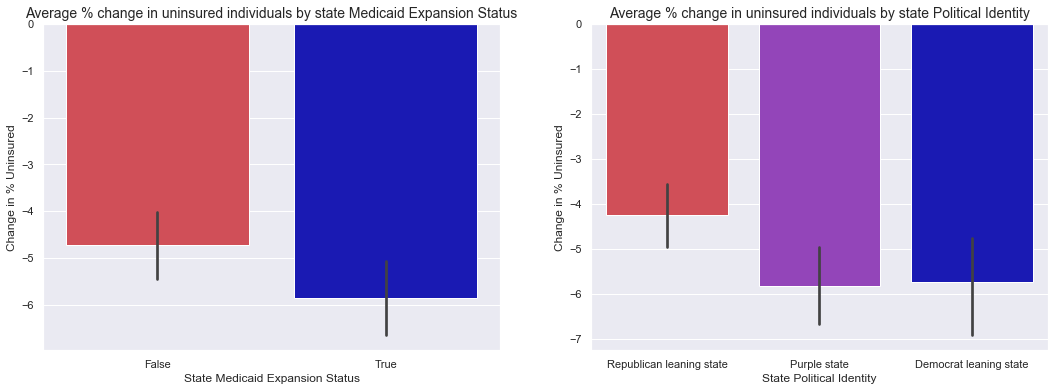

In [24]:
pol_labels= ['Republican leaning state', 'Purple state', 'Democrat leaning state']
color_scheme= ['#E63946', 'darkorchid', 'mediumblue']
binary_scheme = ['#E63946','mediumblue']


plt.figure(figsize=(18,6))

plt.subplot(1, 2, 1)
sns.set(style="darkgrid")
sns.barplot(state_aca_df.medicaid_expansion, state_aca_df.uninsured_rate_change, palette=binary_scheme)
plt.title('Average % change in uninsured individuals by state Medicaid Expansion Status', fontsize=14)
plt.xlabel('State Medicaid Expansion Status')
plt.ylabel('Change in % Uninsured')

plt.subplot(1, 2, 2)
sns.set(style="darkgrid")
sns.barplot(state_aca_df.political_lean, state_aca_df.uninsured_rate_change, palette=color_scheme)
plt.title('Average % change in uninsured individuals by state Political Identity', fontsize=14)
plt.xlabel('State Political Identity')
plt.xticks([0,1,2], labels=pol_labels)
plt.ylabel('Change in % Uninsured')



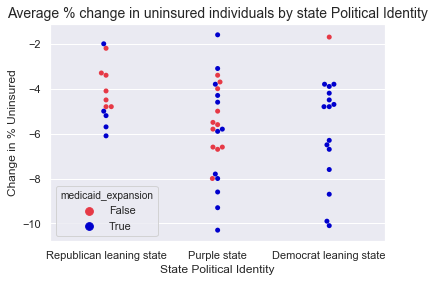

In [11]:
sns.swarmplot(x="political_lean", y="uninsured_rate_change", hue="medicaid_expansion",
              palette=['#E63946','mediumblue'], data=state_aca_df)
sns.set(style="darkgrid")
plt.title('Average % change in uninsured individuals by state Political Identity', fontsize=14)
plt.xlabel('State Political Identity')
plt.xticks([0,1,2], labels=pol_labels)
plt.ylabel('Change in % Uninsured')
plt.show()

The results suggest that state Medicaid Expansion Status and state political leaning correlate with differences in the change in % of individual's uninsured in those states. These differences should be investigated by statistical analysis in order to establish if they reach statistical significance. Before we go any further, let's investigate what other variables in this dataset correlate together.

It also seems that Medicaid Expansion status has high degree of co-variance with state political lean.


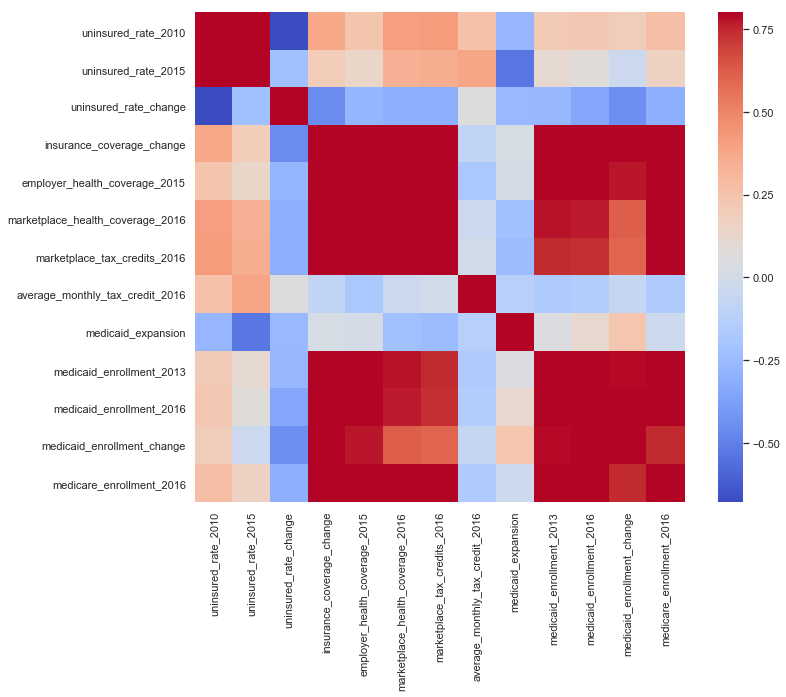

uninsured_rate_2010                -0.677093
uninsured_rate_2015                -0.224251
uninsured_rate_change               1.000000
insurance_coverage_change          -0.454530
employer_health_coverage_2015      -0.277582
marketplace_health_coverage_2016   -0.305778
marketplace_tax_credits_2016       -0.304350
average_monthly_tax_credit_2016     0.064360
medicaid_expansion                 -0.259846
medicaid_enrollment_2013           -0.267051
medicaid_enrollment_2016           -0.344929
medicaid_enrollment_change         -0.441360
medicare_enrollment_2016           -0.308899
Name: uninsured_rate_change, dtype: float64


In [12]:
# Make the correlation matrix.
corrmatrix = state_aca_df.corr()

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmatrix, vmax=.8, square=True, cmap='coolwarm')
plt.show()

print(corrmatrix['uninsured_rate_change'])

It seems that most of the variables in this dataset, with the exception of the data on the distribution of individuals within 200% to 399% of the federal poverty line (2015_200_399_fedpl and 2010_200_399_fedpl) are either weakly or moderately correlated with the % change in insurance rate. There are a number of variables that reach moderate correlation namely:

-2010_100_199_fedpl 
-2015_under_fed_pl 
-health_expense_per_cap
-insurance_coverage_change
-uninsured_rate_2010


It may be worth plotting a scatterplot to visualize how these variables correlate.

The data seems to suggest that states with a greater share of individuals under the federal poverty line or within 100% of the federal poverty line, had greater changes in the percentage of uninsured. This seems to suggest that this endevour greatly affected the number of individuals at or near the poverty.

Text(0, 0.5, 'Change in % Uninsured')

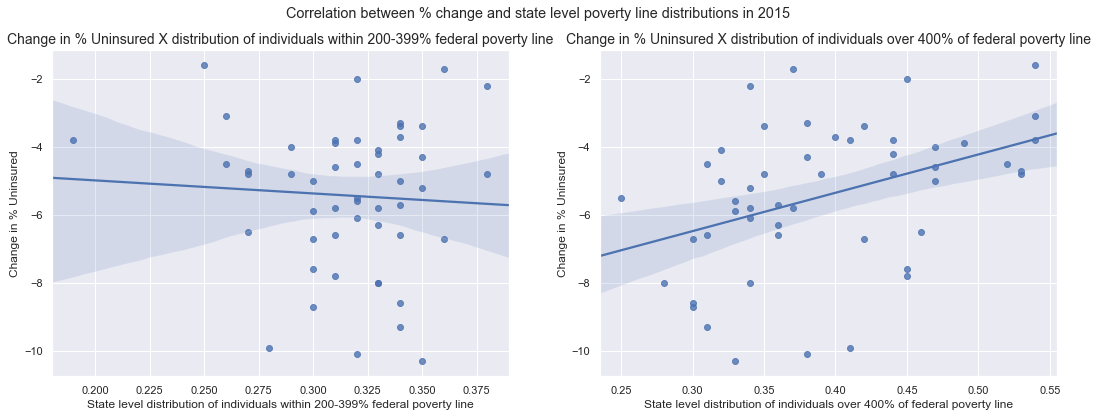

In [14]:
plt.figure(figsize=(18,6))

plt.subplot(1, 2, 1)
plt.suptitle('Correlation between % change and state level poverty line distributions in 2015')
sns.set(style="darkgrid")
sns.regplot(state_aca_df['2015_200_399_fedpl'], state_aca_df['uninsured_rate_change'])
plt.title('Change in % Uninsured X distribution of individuals within 200-399% federal poverty line', fontsize=14)
plt.xlabel('State level distribution of individuals within 200-399% federal poverty line')
plt.ylabel('Change in % Uninsured')

plt.subplot(1, 2, 2)
sns.set(style="darkgrid")
sns.regplot(state_aca_df['2015_over400_pl'], state_aca_df['uninsured_rate_change'])
plt.title('Change in % Uninsured X distribution of individuals over 400% of federal poverty line', fontsize=14)
plt.xlabel('State level distribution of individuals over 400% of federal poverty line')
plt.ylabel('Change in % Uninsured')

This data however is suggestive that the state level percentage of middle class individuals (left graph) is not predictive of change in percentage uninsured. The states with higher percentages of individuals at 400% above the federal poverty line were negatively associated with changes in % uninsured. This is likely explained by the fact that these states did not have as much room to decrease the percentage of individuals without insurance (wealthy people tend to have health insurance). To compound this the ACA specifically gave marketplace incentives to individuals who fall under 400% of the federal poverty line, but not to those above.

## What is the correlation between state politics and state federal poverty level distributions?

[Text(0, 0.5, 'Distribution'), Text(0.5, 0, 'Politcal Lean')]

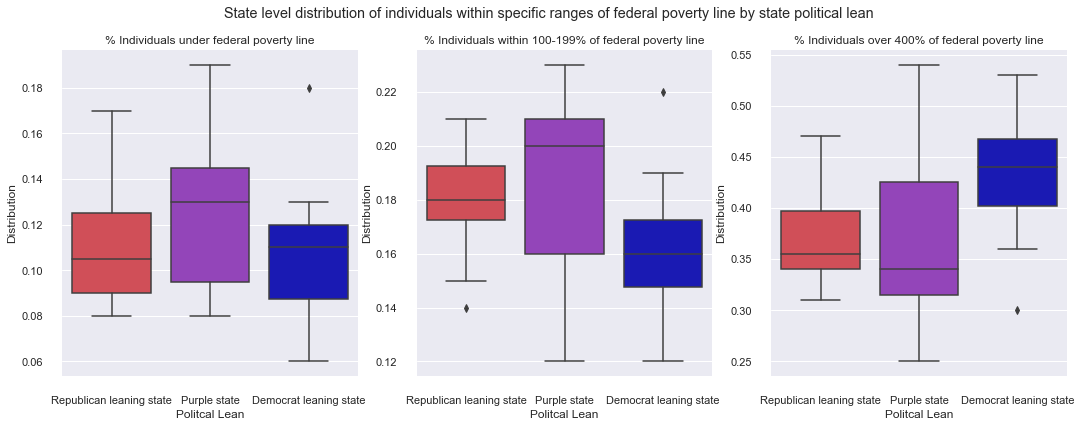

In [32]:

plt.figure(figsize=(18,6))
plt.suptitle('State level distribution of individuals within specific ranges of federal poverty line by state political lean')
plt.subplot(1, 3, 1)
ax = sns.boxplot(x='political_lean',y='2015_under_fed_pl',data=state_aca_df, palette=color_scheme)  
plt.title('% Individuals under federal poverty line')
sns.despine(offset=10, trim=True)
plt.xticks([0,1,2], labels=pol_labels)
ax.set(xlabel='Politcal Lean', ylabel='Distribution')

plt.subplot(1, 3, 2)
ax = sns.boxplot(x='political_lean',y='2015_100_199_fedpl',data=state_aca_df, palette=color_scheme)  
plt.title('% Individuals within 100-199% of federal poverty line')
sns.despine(offset=10, trim=True)
plt.xticks([0,1,2], labels=pol_labels)
ax.set(xlabel='Politcal Lean', ylabel='Distribution')

plt.subplot(1, 3, 3)
ax = sns.boxplot(x='political_lean',y='2015_over400_pl',data=state_aca_df, palette=color_scheme)  
plt.title('% Individuals over 400% of federal poverty line')
sns.despine(offset=10, trim=True)
plt.xticks([0,1,2], labels=pol_labels)
ax.set(xlabel='Politcal Lean', ylabel='Distribution')




Previous data in this dataset has suggested 3 specific findings:

-A negative correlation between % change in uninsured individuals and higher percentages of individuals at 400% or more of federal poverty line
-A positive correlation between % change in uninsured individuals and higher percentages of individuals at 100-199% of federal poverty line and below the federal poverty line
-Greater decreases in % of uninsured individuals in Democratic states when compared to Republican states.

Based on the observations, one might predict that Republican led states could potentially have higher rates of individuals above 400% of the federal poverty line and lower rates of individuals below the 200% and 100% thresholds for the poverty line. In the case of the former (above the 400% threshold), Democratic states in fact have higher levels. Democratic states also have lower numbers of individuals within the 100-200% threshold and a comparable number of individuals below 100% of the federal poverty line. This observations warrant further investigation in order to establish those states which have a high degree of individuals with unmet medical coverage and that will have outsized effects by strategically crafted policy.


------------------------------------------------------------------------------------------------------------------------------

## Preparing dataset for modelling

My outcome variable is change in percentage of uninsured individuals (by state) pre and post ACA.

My feature variables will include:

| Variable name in DF | Description of Variable                                  | Type      |
|---------------------|----------------------------------------------------------|-----------|
| political_lean      | Political Lean of State                                  | -0.241486 |
| 2015_under_fed_pl   | % of individuals under federal poverty line              | -0.432882 |
| 2015_100_199_fedpl  | % of individuals within 100-199% of federal poverty line | -0.512616 |
| 2015_over400_pl     | % of individuals over 400% of federal poverty line      | 0.404311  |
| uninsured_rate_2010 | The uninsured rate in 2010                               | -0.677093 |
| gdppercap_2015      | GDP Per Capita in 2015                                   | 0.277     |


My ten new features are generated below:

## 10 new features

In [25]:
politics_poverty = pd.DataFrame()
politics_poverty['political_lean']=state_aca_df['political_lean']
politics_poverty['underfpl']=state_aca_df['2015_under_fed_pl']
politics_poverty['100199fpl']=state_aca_df['2015_100_199_fedpl']
politics_poverty['over400fpl']=state_aca_df['2015_over400_pl']


scaled_politics_poverty=preprocessing.scale(politics_poverty)

pca = PCA()
pca.fit(scaled_politics_poverty)
pca_data = pca.transform(scaled_politics_poverty)

per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


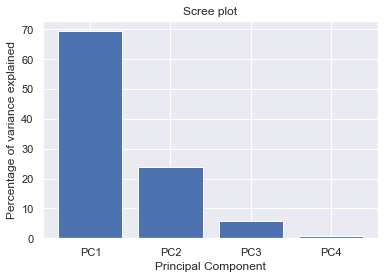

[[ 2.50815114e+00 -7.85628631e-01  8.56116469e-01 -6.29764062e-02]
 [-1.41382929e+00 -1.81749310e+00  1.16764887e-01  2.24015408e-01]
 [ 1.56678130e+00 -1.10336318e+00  3.60417597e-01  6.65105005e-02]
 [ 2.82469547e+00  5.59917616e-01  1.68225644e-01  1.03626999e-01]
 [-8.13642558e-02  1.26257574e+00 -2.10244989e-01  4.17196232e-01]
 [-1.37451159e+00 -4.28342186e-01 -3.94101706e-02 -3.26307476e-02]
 [-2.79986837e+00 -6.03593150e-01  5.71036758e-01  7.57780018e-02]
 [-1.23667068e+00  1.05837978e+00  1.29055133e-01 -2.36847819e-01]
 [-1.54989807e+00 -6.34063282e-02  1.67492607e+00  3.76424163e-01]
 [ 1.29164399e+00  1.18936687e-01 -2.98786214e-01  2.92587820e-01]
 [ 1.45345725e+00  2.86441663e-01  3.29137375e-01 -1.52644949e-02]
 [-2.51855720e+00  7.14315966e-01 -1.38211200e-01 -1.70329075e-01]
 [ 1.79783326e+00  7.43511218e-02 -1.01784424e+00  4.53530640e-01]
 [-7.21309907e-01  1.18195312e+00  1.62815537e-01 -2.08886153e-01]
 [ 1.02921820e+00 -1.32483455e+00 -6.04305872e-02 -1.01315828e

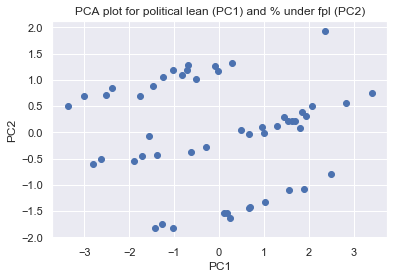

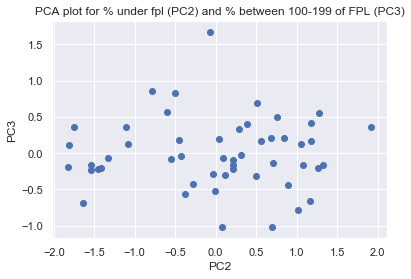

In [26]:
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of variance explained')
plt.xlabel('Principal Component')
plt.title('Scree plot')
plt.show()

# at 850 in video www.youtube.com/watch?v=Lsue2gEM9D0
print(pca_data)

politics_poverty_pca_df = pd.DataFrame(pca_data, columns=labels)

plt.scatter(politics_poverty_pca_df.PC1, politics_poverty_pca_df.PC2)
plt.title('PCA plot for political lean (PC1) and % under fpl (PC2)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

plt.scatter(politics_poverty_pca_df.PC2, politics_poverty_pca_df.PC3)
plt.title('PCA plot for % under fpl (PC2) and % between 100-199 of FPL (PC3)')
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.show()

In [ ]:
#Medicaid * Politics interaction

medicaidXpolitics=state_aca_df['political_lean']

for row in state_aca_df['medicaid_expansion']:
    if row == False:
       #when the row is false, they did not expand medicaid so subtract 1
        medicaidXpolitics = medicaidXpolitics - 1
    # else add 1 when they expanded medicaid
    else:
        medicaidXpolitics = medicaidXpolitics + 1

state_aca_df['medicaidXpolitics'] = medicaidXpolitics

#feature 5 - percentage of individuals under 199% of federal poverty line:

state_aca_df['2015_under199_fed_pl'] = state_aca_df['2015_under_fed_pl'] + state_aca_df['2015_100_199_fedpl']

#feature 6

state_aca_df['2015_over200_fed_pl'] = state_aca_df['2015_200_399_fedpl'] + state_aca_df['2015_over400_pl']

#feature 7

state_aca_df['ratio_rich_to_poor']=state_aca_df['2015_over200_fed_pl']/state_aca_df['2015_under199_fed_pl']

#add PCA results back into original table so we can do a new correlation matrix

state_aca_df['PC1']=politics_poverty_pca_df['PC1'].apply(pd.to_numeric)
state_aca_df['PC2']=politics_poverty_pca_df['PC2'].apply(pd.to_numeric)
state_aca_df['PC3']=politics_poverty_pca_df['PC3'].apply(pd.to_numeric)




My new features are:

1) PC1, 2) PC2, 3) PC3 - the outputs of a PCA (with State Political Lean, % individuals under federal poverty line, between 100-199% of federal poverty line). PC4 was omitted as it was not a significant component of the shared variance within those samples.

Reason: Reduces dimensionality, still retains shared variance of the included variables


4) Medicaid X Politcs - a scalled categorical variable where:

-1: Republican and did not expand medicaid
0: Republic or Purple and did not expand medicaid
1: Republican that expanded medicaid or purple that did not
2: Purple state that expanded medicaid or democratic that did not.
3: Democratic state that expanded medicaid

Reason: Again, reduces dimensionality and includes the information of these two variables which have a clear interdependence.

5) Percentage of individuals under 199% of federal poverty line

Reason: Reduces dimensionality. Meaningful data as the cutoff put is 200% of the federal poverty line for market incentives.

6) Percentage of individuals over 200% of federal poverty line

Reason: See above

Let's re do the correlation matrix with these variables:

7) Ratio 'rich' to poor (ratio of individuals over 200% of federal poverty to individuals under 200% of federal poverty line

Further reduces dimensionality includes key info pertaining to reduction in individuals uninsured.

8, 9, 10: I've feature engineered lot's of features into this data set...i'm going to stop here for fear of encountering the curse of dimensionality...

In [ ]:
# Make the correlation matrix.
corrmatrix = state_aca_df.corr()

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmatrix, vmax=.8, square=True, cmap='coolwarm')
plt.show()

print(corrmatrix['uninsured_rate_change'].abs().sort_values(ascending=False))

Top 5 are:

uninsured_rate_2010                           0.677093
2015_100_199_fedpl                            0.512616
health_expense_per_cap_2011                   0.498907
2015_under199_fed_pl                          0.496695
health_expense_per_cap_2009                   0.496485

I've picked these as they are the most correlated with the outcome variable.

------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------

# Modelling:

My purpose here is to find the model that most accurately

Decision's Trees,
Random Forest, 
Gradient Boost,
Linear regression (and if appropriate other forms of regression),
Support Vector Machines,
K-nearest neighbors.

For each model, I will go through the following steps:

Create a test-train split to test the model against overfitting.
Evaluation metrics: cross-validation scores on the training data, as well as confusion matricies.
Feature assessment and tweaking via PCA, GridSearchCV (where appropriate)

Our ideal outcome model will:
High predictive accuracy in predicting % change in uninsured individuals.
Allow us to attribute the predictive accuracy of the model to particular features.

# Let's try random forest and decision trees and see how they do with this model.

First of all, let's try running random forest on the whole dataset with just a few of the more lower correlated values removed. If we need to re-adjust the model so that we only use the most highly correlated variables (listed above), then let's persue that option. We will also adjust our outcome variable into 9 percentile groups and classify them based on which percentile range they fall into.

In [29]:
state_aca_df['uninsured_rate_change'].min()



-10.3

In [30]:
#might be better to create a categorical variable that includes neutral states
uninsured_change_cat=[]

for row in state_aca_df['uninsured_rate_change']:
    if row >=-10.3 and row <=-8.6:
        uninsured_change_cat.append(10)
    elif row <= -6.7 and row >=-8.6:
        uninsured_change_cat.append(9)
    elif row <= -6.3 and row >=-6.7:
        uninsured_change_cat.append(8)
    elif row <= -5.7 and row >=-6.3:
        uninsured_change_cat.append(7)
    elif row <= -5.0 and row >=-5.7:
        uninsured_change_cat.append(6)
    elif row <= -4.7 and row >=-5.0:
        uninsured_change_cat.append(5)
    elif row <= -4.2 and row >=-4.7:
        uninsured_change_cat.append(4)
    elif row <= -3.8 and row >=-4.2:
        uninsured_change_cat.append(3)
    elif row <= -3.3 and row -3.8:
        uninsured_change_cat.append(2)
    elif row >= -3.3:
        uninsured_change_cat.append(1)
    
    #create a column based on this output
state_aca_df['uninsured_change_cat'] = uninsured_change_cat

print(state_aca_df['uninsured_change_cat'])

0      4
1      6
2      7
3      9
4     10
5      9
6      1
7      3
8      3
9      9
10     7
11     3
12     9
13     9
14     6
15     4
16     5
17    10
18     7
19     1
20     5
21     1
22     8
23     4
24     6
25     2
26     7
27     2
28    10
29     5
30     4
31    10
32     5
33     6
34     1
35     7
36     6
37    10
38     3
39     8
40     8
41     1
42     3
43     8
44     5
45     4
46     3
47     9
48    10
49     2
50     2
Name: uninsured_change_cat, dtype: int64


In [65]:
#remove any data relating to rate changes
rf_regression_data=state_aca_df.drop('State', 1)
#remove the 4 lowest correlates and the uninsured rate data and then let's run again
rf_regression_data_reduced=rf_regression_data.drop('2010_200_399_fedpl', 1)
rf_regression_data_reduced=rf_regression_data_reduced.drop('average_monthly_tax_credit_2016', 1)
rf_regression_data_reduced=rf_regression_data_reduced.drop('2015_200_399_fedpl', 1)
rf_regression_data_reduced=rf_regression_data_reduced.drop('PC3', 1)
rf_regression_data_reduced=rf_regression_data_reduced.drop('uninsured_rate_2015', 1)
rf_regression_data_reduced=rf_regression_data_reduced.drop('uninsured_change_cat', 1)
rf_regression_data_reduced=rf_regression_data_reduced.drop('uninsured_rate_change', 1)

In [67]:
#quick check that everything is in order...
rf_regression_data_reduced.head()



,uninsured_rate_2010,insurance_coverage_change,employer_health_coverage_2015,marketplace_health_coverage_2016,marketplace_tax_credits_2016,medicaid_expansion,medicaid_enrollment_2013,medicaid_enrollment_2016,medicaid_enrollment_change,medicare_enrollment_2016,...,2015_100_199_fedpl,2010_100_199_fedpl,2015_over400_pl,2010_over400_pl,medicaidXpolitics,2015_under199_fed_pl,2015_over200_fed_pl,ratio_rich_to_poor,PC1,PC2
0,14.6,215000,2545000,165534,152206,False,799176.0,910775,111599.0,989855,...,0.21,0.21,0.31,0.30,13,0.38,0.63,1.657895,2.508151,-0.785629
1,19.9,36000,390000,17995,16205,True,122334.0,166625,44291.0,88966,...,0.15,0.16,0.47,0.46,13,0.23,0.77,3.347826,-1.413829,-1.817493
2,16.9,410000,3288000,179445,124346,True,1201770.0,1716198,514428.0,1175624,...,0.20,0.21,0.34,0.32,13,0.34,0.66,1.941176,1.566781,-1.103363
3,17.5,234000,1365000,63357,56843,True,556851.0,920194,363343.0,606146,...,0.23,0.25,0.28,0.27,14,0.40,0.61,1.525000,2.824695,0.559918
4,18.5,3826000,19552000,1415428,1239893,True,7755381.0,11843081,4087700.0,5829777,...,0.19,0.20,0.41,0.38,15,0.31,0.69,2.225806,-0.081364,1.262576


<h1><center>Decision trees</center></h1>

In [66]:
# This is the starting model we will use
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

#split data

X = rf_regression_data_reduced
X = X.dropna(axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, state_aca_df['uninsured_change_cat'], test_size=0.4, random_state=1)


# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4,
    random_state = 1337
)

decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.14285714285714285


Not especially, accurate. Let's try again.

In [69]:
# Let's try changing the features
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

#split data

X = rf_regression_data
X = X.dropna(axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, state_aca_df['uninsured_change_cat'], test_size=0.4, random_state=1)


# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=4,
    max_depth=4,
    random_state = 1337
)

decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.09523809523809523


In [70]:
# Let's try changing the depth
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

#split data

X = rf_regression_data
X = X.dropna(axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, state_aca_df['uninsured_change_cat'], test_size=0.4, random_state=1)


# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=4,
    max_depth=8,
    random_state = 1337
)

decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.09523809523809523


Using more features has no impact. 

Nor does changing max depth. As a final measure let's try to make the test size bigger as we're working with a small sample size.

In [71]:
# This is the model we'll be using.
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
# A convenience for displaying visualizations.
from IPython.display import Image
import time
start_time = time.time()

# Packages for rendering our tree.
import pydotplus
import graphviz

#split data

X = rf_regression_data_reduced
X = X.dropna(axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, state_aca_df['uninsured_change_cat'], test_size=0.7, random_state=1)


# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=4,
    max_depth=8,
    random_state = 1337
)

decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("--- %s seconds ---" % (time.time() - start_time))

Accuracy: 0.1111111111111111
--- 0.009943485260009766 seconds ---


Try using gridsearchCV (?) - make a list of hyperparameters....gridsearch tries different combinations and helps optimize the hyperparameters...

In [111]:
#try grid search here

# let's try gridsearch here...
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
# A convenience for displaying visualizations.
from IPython.display import Image
import time
start_time = time.time()

# Packages for rendering our tree.

#split data

X = rf_regression_data_reduced
X = X.dropna(axis=1)
Y=state_aca_df['uninsured_change_cat']

X_train, X_test, y_train, y_test = train_test_split(X, state_aca_df['uninsured_change_cat'], test_size=0.7, random_state=1)


# Initialize and train our tree using gridsearchcv

decision_tree = tree.DecisionTreeClassifier()
parameters = {'criterion': ['gini', 'entropy'], 'max_features': [2,4,8], 'max_depth':[2,4,8]}
gridsearch  = GridSearchCV(estimator=decision_tree, param_grid=parameters, cv=8, n_jobs=-1)

gridsearch.fit(X, Y)

print("Best score: %0.3f" % gridsearch.best_score_)
print("Best parameters set:")
best_parameters=gridsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=8.
  % (min_groups, self.n_splits)), Warning)


Best score: 0.216
Best parameters set:
	criterion: 'gini'
	max_depth: 2
	max_features: 2


D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


This is better, but not by much. Let's try and train and test this model with these settings:

In [116]:
# This is the model we'll be using.
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
# A convenience for displaying visualizations.
from IPython.display import Image
import time
start_time = time.time()

# Packages for rendering our tree.
import pydotplus
import graphviz

#split data

X = rf_regression_data_reduced
X = X.dropna(axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, state_aca_df['uninsured_change_cat'], test_size=0.9, random_state=1)


# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='gini',
    max_features=2,
    max_depth=2,
    random_state = 1337
)

decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("--- %s seconds ---" % (time.time() - start_time))

Accuracy: 0.10869565217391304
--- 0.008889913558959961 seconds ---


Not sure GridSearch CV did anything but overfit this data.

<h1><center>Random Forest</center></h1>

In [39]:
import time
start_time = time.time()

rf= ensemble.RandomForestRegressor()
X = rf_regression_data_reduced
X = X.dropna(axis=1)
Y = state_aca_df['uninsured_rate_change']
rf.fit(X, Y)

print(cross_val_score(rf, X, Y, cv=5))
print("--- %s seconds ---" % (time.time() - start_time))

[0.62749468 0.51000109 0.46041684 0.5853211  0.32777748]
--- 0.07380342483520508 seconds ---


D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Works, but there's a pretty large variance here. Also not a huge difference between the RF and DT. The DT runs significantly faster and the RF is slightly more accurate.

Perhaps a product of having n=52, which is a relatively small sample size. Maybe I could generate some synthetic data? Also worth considering trying this as a classificaiton and creating bins for changes in uninsured rate.

# Run RF as a classifer with % change in uninsured as a scaled categorical variable

In [45]:
start_time = time.time()



rf_rc2= ensemble.RandomForestClassifier()
X = rf_regression_data_reduced
X = X.dropna(axis=1)
Y = state_aca_df['uninsured_change_cat']
rf_rc2.fit(X, Y)
print(cross_val_score(rf_rc2, X, Y, cv=5))
print("--- %s seconds ---" % (time.time() - start_time))



[0.15384615 0.         0.3        0.1        0.125     ]
--- 0.07483625411987305 seconds ---


D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Does not work better as a classifer with the decile data.

In [74]:
#let's check what we can remove..
rf_regression_data['uninsured_change_cat'] = state_aca_df['uninsured_change_cat']

# Make the correlation matrix.
corrmatrix = state_aca_df.corr()

print(corrmatrix['uninsured_change_cat'].abs().sort_values(ascending=False))

uninsured_change_cat                          1.000000
uninsured_rate_change                         0.951393
uninsured_rate_2010                           0.691838
2015_100_199_fedpl                            0.533331
2015_under199_fed_pl                          0.525881
2015_over200_fed_pl                           0.521096
ratio_rich_to_poor                            0.514728
2010_100_199_fedpl                            0.504546
health_expense_per_cap_2009                   0.475121
health_expense_per_cap_2011                   0.470429
2015_under_fed_pl                             0.468024
health_expense_per_cap_2010                   0.467017
2010_under_fed_pl                             0.460204
health_expense_per_cap_2013                   0.455559
health_expense_per_cap_2012                   0.455559
PC1                                           0.454710
health_expense_per_cap_2014                   0.433905
2015_over400_pl                               0.428995
insurance_

In [75]:
rf_regression_data_reduced.head()

,uninsured_rate_2010,insurance_coverage_change,employer_health_coverage_2015,marketplace_health_coverage_2016,marketplace_tax_credits_2016,medicaid_expansion,medicaid_enrollment_2013,medicaid_enrollment_2016,medicaid_enrollment_change,medicare_enrollment_2016,...,2015_100_199_fedpl,2010_100_199_fedpl,2015_over400_pl,2010_over400_pl,medicaidXpolitics,2015_under199_fed_pl,2015_over200_fed_pl,ratio_rich_to_poor,PC1,PC2
0,14.6,215000,2545000,165534,152206,False,799176.0,910775,111599.0,989855,...,0.21,0.21,0.31,0.30,13,0.38,0.63,1.657895,2.508151,-0.785629
1,19.9,36000,390000,17995,16205,True,122334.0,166625,44291.0,88966,...,0.15,0.16,0.47,0.46,13,0.23,0.77,3.347826,-1.413829,-1.817493
2,16.9,410000,3288000,179445,124346,True,1201770.0,1716198,514428.0,1175624,...,0.20,0.21,0.34,0.32,13,0.34,0.66,1.941176,1.566781,-1.103363
3,17.5,234000,1365000,63357,56843,True,556851.0,920194,363343.0,606146,...,0.23,0.25,0.28,0.27,14,0.40,0.61,1.525000,2.824695,0.559918
4,18.5,3826000,19552000,1415428,1239893,True,7755381.0,11843081,4087700.0,5829777,...,0.19,0.20,0.41,0.38,15,0.31,0.69,2.225806,-0.081364,1.262576


In [46]:
start_time = time.time()

rf_rc2= ensemble.RandomForestClassifier()
X = rf_regression_data_reduced
X = X.dropna(axis=1)
Y = state_aca_df['uninsured_change_cat']
rf_rc2.fit(X, Y)
print(cross_val_score(rf, X, Y, cv=5))
print("--- %s seconds ---" % (time.time() - start_time))

[0.7512996  0.68558077 0.24032043 0.50228495 0.48458198]
--- 0.07180929183959961 seconds ---


D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Again, looks somewhat better. Let's try and further reduce dimensionality and try a final time.

In [77]:
#let's take a look at what can still be removed
rf_regression_data_reduced.head()

,uninsured_rate_2010,insurance_coverage_change,employer_health_coverage_2015,marketplace_health_coverage_2016,marketplace_tax_credits_2016,medicaid_expansion,medicaid_enrollment_2013,medicaid_enrollment_2016,medicaid_enrollment_change,medicare_enrollment_2016,...,2015_100_199_fedpl,2010_100_199_fedpl,2015_over400_pl,2010_over400_pl,medicaidXpolitics,2015_under199_fed_pl,2015_over200_fed_pl,ratio_rich_to_poor,PC1,PC2
0,14.6,215000,2545000,165534,152206,False,799176.0,910775,111599.0,989855,...,0.21,0.21,0.31,0.30,13,0.38,0.63,1.657895,2.508151,-0.785629
1,19.9,36000,390000,17995,16205,True,122334.0,166625,44291.0,88966,...,0.15,0.16,0.47,0.46,13,0.23,0.77,3.347826,-1.413829,-1.817493
2,16.9,410000,3288000,179445,124346,True,1201770.0,1716198,514428.0,1175624,...,0.20,0.21,0.34,0.32,13,0.34,0.66,1.941176,1.566781,-1.103363
3,17.5,234000,1365000,63357,56843,True,556851.0,920194,363343.0,606146,...,0.23,0.25,0.28,0.27,14,0.40,0.61,1.525000,2.824695,0.559918
4,18.5,3826000,19552000,1415428,1239893,True,7755381.0,11843081,4087700.0,5829777,...,0.19,0.20,0.41,0.38,15,0.31,0.69,2.225806,-0.081364,1.262576


In [48]:
rf_regression_data_reduced=rf_regression_data_reduced.drop('2015_under199_fed_pl', 1)
rf_regression_data_reduced=rf_regression_data_reduced.drop('2015_over200_fed_pl', 1)
rf_regression_data_reduced=rf_regression_data_reduced.drop('2010_over400_pl', 1)
rf_regression_data_reduced=rf_regression_data_reduced.drop('2010_100_199_fedpl', 1)
rf_regression_data_reduced=rf_regression_data_reduced.drop('2015_100_199_fedpl', 1)



In [49]:
#let's take a look at what can still be removed
rf_regression_data_reduced.head()

,uninsured_rate_2010,insurance_coverage_change,employer_health_coverage_2015,marketplace_health_coverage_2016,marketplace_tax_credits_2016,medicaid_expansion,medicaid_enrollment_2013,medicaid_enrollment_2016,medicaid_enrollment_change,medicare_enrollment_2016,...,health_expense_per_cap_2010,health_expense_per_cap_2009,private_health_insurance_spending_millions,2015_under_fed_pl,2010_under_fed_pl,2015_over400_pl,medicaidXpolitics,ratio_rich_to_poor,PC1,PC2
0,14.6,215000,2545000,165534,152206,False,799176.0,910775,111599.0,989855,...,6421,6325,11078,0.17,0.17,0.31,13,1.657895,2.508151,-0.785629
1,19.9,36000,390000,17995,16205,True,122334.0,166625,44291.0,88966,...,9129,8745,2492,0.08,0.08,0.47,13,3.347826,-1.413829,-1.817493
2,16.9,410000,3288000,179445,124346,True,1201770.0,1716198,514428.0,1175624,...,6027,5874,15073,0.14,0.14,0.34,13,1.941176,1.566781,-1.103363
3,17.5,234000,1365000,63357,56843,True,556851.0,920194,363343.0,606146,...,6412,6238,6209,0.17,0.16,0.28,14,1.525000,2.824695,0.559918
4,18.5,3826000,19552000,1415428,1239893,True,7755381.0,11843081,4087700.0,5829777,...,6480,6210,104018,0.12,0.13,0.41,15,2.225806,-0.081364,1.262576


In [50]:
start_time = time.time()

rf_rc2= ensemble.RandomForestClassifier()
X = rf_regression_data_reduced
X = X.dropna(axis=1)
Y = state_aca_df['uninsured_change_cat']

print(cross_val_score(rf, X, Y, cv=5))
print("--- %s seconds ---" % (time.time() - start_time))

[0.79156746 0.64859813 0.46248331 0.15591398 0.36536374]
--- 0.06183648109436035 seconds ---


Still no major difference. There's still room to remove variables here...part of the variability in this model is likely due to the high number of variables...among which there is high variance in correlation.

Problem with random forest/decision trees = make sure distribution is normal and balanced. SMOTE can help with this. This should be my first port of call along with further dimensionality reduction.

In [67]:
rf_regression_data_reduced=rf_regression_data_reduced.drop('health_expense_per_cap_2009', 1)
rf_regression_data_reduced=rf_regression_data_reduced.drop('2015_under_fed_pl', 1)
rf_regression_data_reduced=rf_regression_data_reduced.drop('gdppercap_2013', 1)
rf_regression_data_reduced=rf_regression_data_reduced.drop('gdppercap_2014', 1)
rf_regression_data_reduced=rf_regression_data_reduced.drop('medicaid_enrollment_2016', 1)

rf_regression_data_reduced=rf_regression_data_reduced.drop('gdppercap_2011', 1)
rf_regression_data_reduced=rf_regression_data_reduced.drop('gdppercap_2010', 1)
rf_regression_data_reduced=rf_regression_data_reduced.drop('medicaid_enrollment_2013', 1)

#stuff i can still  remove:

#2015_100_199_fedpl                            0.533331
#2015_under199_fed_pl                          0.525881
#2015_over200_fed_pl                           0.521096
#ratio_rich_to_poor                            0.514728
#2010_100_199_fedpl                            0.504546

#health_expense_per_cap_2011                   0.470429
#2015_under_fed_pl                             0.468024
#health_expense_per_cap_2010                   0.467017
#2010_under_fed_pl                             0.460204
#health_expense_per_cap_2013                   0.455559
#health_expense_per_cap_2012                   0.455559
#PC1                                           0.454710
#health_expense_per_cap_2014                   0.433905
#2015_over400_pl                               0.428995
#insurance_coverage_change                     0.413168
#PC2                                           0.411653
#2010_over400_pl                               0.406959
#medicaid_enrollment_change                    0.370644
#gdppercap_2012                                0.323737

#gdppercap_2015                                0.312468

#medicare_enrollment_2016                      0.287244
#marketplace_health_coverage_2016              0.282511
#marketplace_tax_credits_2016                  0.280041
#uninsured_rate_2015                           0.276461
#medicaid_expansion                            0.260766
#employer_health_coverage_2015                 0.258529

#private_health_insurance_spending_millions    0.239035
#medicaidXpolitics                             0.231862
#political_lean                                0.231862


In [68]:
start_time = time.time()

rf_rc2= ensemble.RandomForestClassifier()
X = rf_regression_data_reduced
X = X.dropna(axis=1)
Y = state_aca_df['uninsured_change_cat']

print(cross_val_score(rf, X, Y, cv=5))
print("--- %s seconds ---" % (time.time() - start_time))

[0.6614881  0.52510013 0.49105474 0.39879032 0.26514658]
--- 0.06482386589050293 seconds ---


Variance seems to be going in the right direction..let's keep going..

In [69]:
#rf_regression_data_reduced=rf_regression_data_reduced.drop('health_expense_per_cap_2014', 1)
#rf_regression_data_reduced=rf_regression_data_reduced.drop('gdppercap_2015', 1)
#rf_regression_data_reduced=rf_regression_data_reduced.drop('private_health_insurance_spending_millions', 1)

rf_regression_data_reduced=rf_regression_data_reduced.drop('marketplace_tax_credits_2016', 1)


#stuff i can still  remove:

#2015_100_199_fedpl                            0.533331
#2015_under199_fed_pl                          0.525881
#2015_over200_fed_pl                           0.521096
#ratio_rich_to_poor                            0.514728
#2010_100_199_fedpl                            0.504546

#health_expense_per_cap_2011                   0.470429
#2015_under_fed_pl                             0.468024
#health_expense_per_cap_2010                   0.467017
#2010_under_fed_pl                             0.460204
#health_expense_per_cap_2013                   0.455559
#health_expense_per_cap_2012                   0.455559
#PC1                                           0.454710

#2015_over400_pl                               0.428995
#insurance_coverage_change                     0.413168
#PC2                                           0.411653
#2010_over400_pl                               0.406959
#medicaid_enrollment_change                    0.370644
#gdppercap_2012                                0.323737



#medicare_enrollment_2016                      0.287244
#marketplace_health_coverage_2016              0.282511

#medicaid_expansion                            0.260766
#employer_health_coverage_2015                 0.258529


#medicaidXpolitics                             0.231862
#political_lean                                0.231862


In [70]:
start_time = time.time()

rf_rc2= ensemble.RandomForestClassifier()
X = rf_regression_data_reduced
X = X.dropna(axis=1)
Y = state_aca_df['uninsured_change_cat']

print(cross_val_score(rf, X, Y, cv=5))
print("--- %s seconds ---" % (time.time() - start_time))

[0.77105159 0.57463284 0.54913218 0.59986559 0.46015201]
--- 0.057877302169799805 seconds ---


In [ ]:
rf_regression_data_reduced.head()

In [ ]:
rf_regression_data_reduced=rf_regression_data_reduced.drop('employer_health_coverage_2015', 1)
rf_regression_data_reduced=rf_regression_data_reduced.drop('medicare_enrollment_2016', 1)
rf_regression_data_reduced=rf_regression_data_reduced.drop('health_expense_per_cap_2013', 1)


#health_expense_per_cap_2012                   0.455559
#PC1                                           0.454710

#2015_over400_pl                               0.428995
#insurance_coverage_change                     0.413168
#PC2                                           0.411653
#2010_over400_pl                               0.406959
#medicaid_enrollment_change                    0.370644
#gdppercap_2012                                0.323737



#medicaid_expansion                            0.260766


#medicaidXpolitics                             0.231862
#political_lean                                0.231862

In [ ]:
start_time = time.time()

rf_rc2= ensemble.RandomForestClassifier()
X = rf_regression_data_reduced
X = X.dropna(axis=1)
Y = state_aca_df['uninsured_change_cat']

print(cross_val_score(rf, X, Y, cv=5))
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
rf_regression_data_reduced.head()

In [ ]:
rf_regression_data_reduced=rf_regression_data_reduced.drop('health_expense_per_cap_2011', 1)
rf_regression_data_reduced=rf_regression_data_reduced.drop('health_expense_per_cap_2010', 1)

In [85]:
start_time = time.time()

rf_rc2= ensemble.RandomForestClassifier()
X = rf_regression_data_reduced
X = X.dropna(axis=1)
Y = state_aca_df['uninsured_change_cat']

print(cross_val_score(rf, X, Y, cv=2))
print("--- %s seconds ---" % (time.time() - start_time))

[0.35694007 0.48527954]
--- 0.03388643264770508 seconds ---


D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


I think I've got this backwards. Let's try adding variables one by one from this list instead:

uninsured_rate_2010                           0.691838
2015_100_199_fedpl                            0.533331
2015_under199_fed_pl                          0.525881
2015_over200_fed_pl                           0.521096
ratio_rich_to_poor                            0.514728
2010_100_199_fedpl                            0.504546
health_expense_per_cap_2009                   0.475121
health_expense_per_cap_2011                   0.470429
2015_under_fed_pl                             0.468024
health_expense_per_cap_2010                   0.467017
2010_under_fed_pl                             0.460204
health_expense_per_cap_2013                   0.455559
health_expense_per_cap_2012                   0.455559
PC1                                           0.454710
health_expense_per_cap_2014                   0.433905
2015_over400_pl                               0.428995
insurance_coverage_change                     0.413168
PC2                                           0.411653
2010_over400_pl                               0.406959
medicaid_enrollment_change                    0.370644
gdppercap_2012                                0.323737
gdppercap_2013                                0.318105
gdppercap_2014                                0.317612
medicaid_enrollment_2016                      0.313829
gdppercap_2015                                0.312468
gdppercap_2011                                0.310643
gdppercap_2010                                0.299206
medicare_enrollment_2016                      0.287244
marketplace_health_coverage_2016              0.282511
marketplace_tax_credits_2016                  0.280041
uninsured_rate_2015                           0.276461
medicaid_expansion                            0.260766
employer_health_coverage_2015                 0.258529
medicaid_enrollment_2013                      0.253278
private_health_insurance_spending_millions    0.239035
medicaidXpolitics                             0.231862
political_lean                                0.231862
PC3                                           0.114192
2015_200_399_fedpl                            0.072603
average_monthly_tax_credit_2016               0.069749
2010_200_399_fedpl                            0.035352

## Final RF model

In [131]:
finalmodel_df=pd.DataFrame()

finalmodel_df['health_expense_per_cap_2012']=state_aca_df['health_expense_per_cap_2012']
finalmodel_df['ratio_rich_to_poor']=state_aca_df['ratio_rich_to_poor']
finalmodel_df['uninsured_rate_2010']=state_aca_df['uninsured_rate_2010']
finalmodel_df['political_lean']=state_aca_df['political_lean']
finalmodel_df['medicaid_expansion']=state_aca_df['medicaid_expansion']


rf_rc2= ensemble.RandomForestClassifier()
X = finalmodel_df
X = X.dropna(axis=1)
Y = state_aca_df['uninsured_change_cat']
rf_rc2.fit(X, Y)

print(rf_rc2.score(X, Y))

0.9803921568627451


D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=1)

rf_rc2.fit(X_train, y_train)

print(rf_rc2.score(X_test, y_test))


0.11538461538461539


This is gpod, but the test/train data doesn't work out great. Likely a product of the low sample size.

<h1><center>Multivariable Linear Regression</center></h1>

Let's do a quick test on the  whole dataset first:

In [133]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [-4.56021176e-04 -9.34799028e-01  4.18844444e-01  9.78061052e-01
  2.74337584e+00]

Intercept: 
 2.956122555988567

R-squared:
0.8024392015415871


Looks pretty decent, let's try one other validation method.

In [134]:
print(cross_val_score(rf, X, Y, cv=10))
print("--- %s seconds ---" % (time.time() - start_time))

[0.72823529 0.74490741 0.52824675 0.4900463  0.24115854 0.70349462
 0.65771028 0.635      0.5988806  0.46480892]
--- 2617.7331409454346 seconds ---


This model looks pretty good. Let's try to train and test it:



In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.9, random_state=1)


In [136]:
print(regr.score(X_test, y_test))

0.8000009248484761


Looks great but we're doing this on the decile data...let's run the raw data:

In [ ]:
Let's also try this regression model with the raw data just to see if it fits better:

In [140]:
Y1 = state_aca_df['uninsured_rate_change']

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
regr.fit(X, Y1)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 4.15031566e-04  5.71305534e-01 -2.91405617e-01 -7.12066612e-01
 -2.03242148e+00]

Intercept: 
 -4.039735840194501

R-squared:
0.7814266713082993


In [147]:
RX_train, RX_test, RY_train, RY_test = train_test_split(X, Y1, test_size=0.5, random_state=6666)

In [148]:
regr = linear_model.LinearRegression()
regr.fit(RX_train, RY_train)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(RX_train, RY_train))


Coefficients: 
 [ 2.93503422e-04  7.58249400e-01 -2.13395549e-01 -8.63719662e-01
 -1.90373347e+00]

Intercept: 
 -4.668369792724917

R-squared:
0.7200774337116046


In [149]:
print(regr.score(RX_test, RY_test))

0.7622455008709657


Our multivariable regression model is the best to date and by a large margin. Let's take a look at how the variables we've included correlate with our outcome variable:

finalmodel_df['health_expense_per_cap_2012']=state_aca_df['health_expense_per_cap_2012']
finalmodel_df['ratio_rich_to_poor']=state_aca_df['ratio_rich_to_poor']
finalmodel_df['uninsured_rate_2010']=state_aca_df['uninsured_rate_2010']
finalmodel_df['political_lean']=state_aca_df['political_lean']
finalmodel_df['medicaid_expansion']=state_aca_df['medicaid_expansion']

Text(0, 0.5, '')

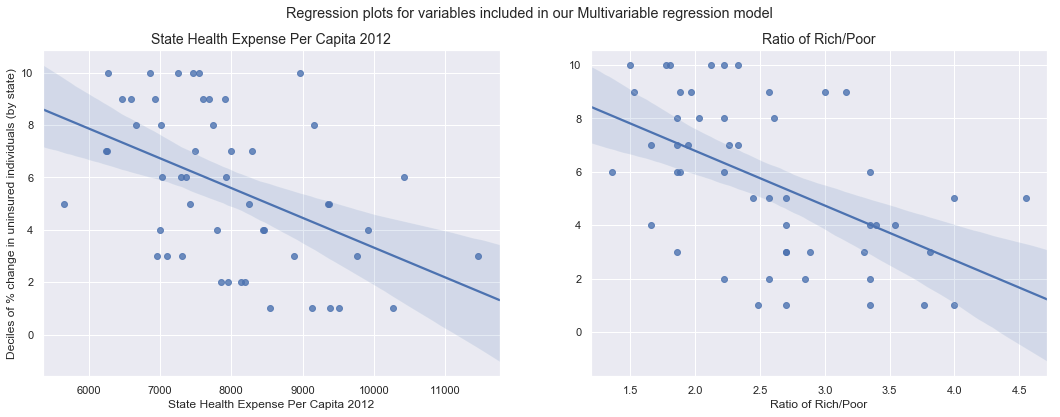

In [181]:
plt.figure(figsize=(18,6))

plt.subplot(1, 2, 1)
plt.suptitle('Regression plots for variables included in our Multivariable regression model')
sns.set(style="darkgrid")
sns.regplot(state_aca_df['health_expense_per_cap_2012'], Y)
plt.title('State Health Expense Per Capita 2012', fontsize=14)
plt.xlabel('State Health Expense Per Capita 2012')
plt.ylabel('Deciles of % change in uninsured individuals (by state)')

plt.subplot(1, 2, 2)
sns.set(style="darkgrid")
sns.regplot(state_aca_df['ratio_rich_to_poor'], Y)
plt.title('Ratio of Rich/Poor', fontsize=14)
plt.xlabel('Ratio of Rich/Poor')
plt.ylabel('')

Text(0, 0.5, '')

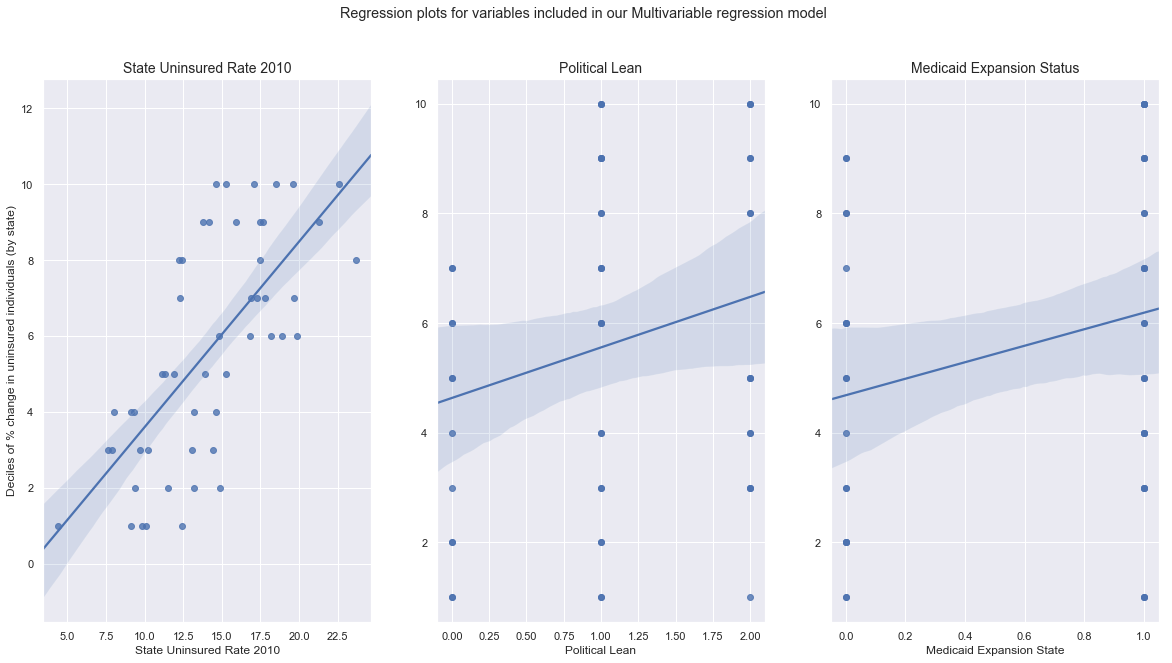

In [186]:
plt.figure(figsize=(20,10))

plt.subplot(1, 3, 1)
plt.suptitle('Regression plots for variables included in our Multivariable regression model')
sns.set(style="darkgrid")
sns.regplot(state_aca_df['uninsured_rate_2010'], Y)
plt.title('State Uninsured Rate 2010', fontsize=14)
plt.xlabel('State Uninsured Rate 2010')
plt.ylabel('Deciles of % change in uninsured individuals (by state)')

plt.subplot(1, 3, 2)
sns.set(style="darkgrid")
sns.regplot(state_aca_df['political_lean'], Y)
plt.title('Political Lean', fontsize=14)
plt.xlabel('Political Lean')
plt.ylabel('')

plt.subplot(1, 3, 3)
sns.set(style="darkgrid")
sns.regplot(state_aca_df['medicaid_expansion'], Y)
plt.title('Medicaid Expansion Status', fontsize=14)
plt.xlabel('Medicaid Expansion State')
plt.ylabel('')



<h1><center>Support Vector Machines</center></h1>

<h1><center>Gradient Boost</center></h1>

In [208]:
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size=0.9, random_state=1)

In [209]:
params = {'n_estimators': 2,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train1, Y_train1)

predict_train = clf.predict(X)

#score
clf.score(X_train1, Y_train1)


1.0

In [210]:
clf.score(X_test1, Y_test1)

0.13043478260869565

Given the lack of data here, it's almost impossible not to overfit. We're really going to have to try smote. There's no point trying to optimize these models any further as they will not out perform our regression model.

In [211]:
import imbalanced-learn as imb

SyntaxError: invalid syntax (<ipython-input-211-e2e9643d6a1c>, line 1)